In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
labels = pd.read_csv("rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
len(labels) # 496 X-Ray images in the dataset

496

In [4]:
ROOT_PATH = Path("/Users/rapapps1/Documents/Courses_online/Udemy/AI-IN-MEDICAL-MATERIALS/Data/rsna-pneumonia-detection-challenge/stage_2_train_images/", )
SAVE_PATH = Path("Processed-Heart-Detection/")
SAVE_PATH.mkdir(parents=True, exist_ok=True)

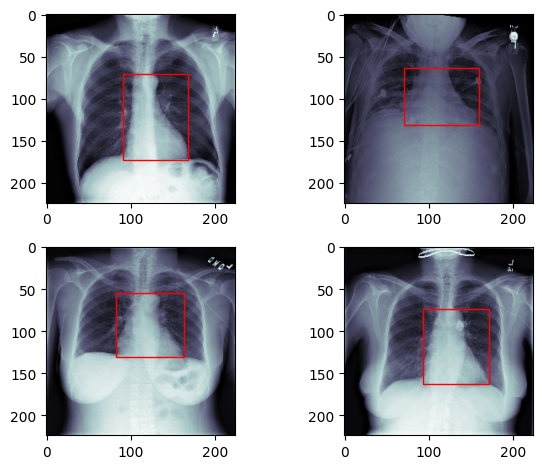

In [5]:
fig, axis = plt.subplots(2,2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm files
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path)
        # Retrieve the actual image and resize it to match the labels
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        # Labels taken on the resized images
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="r", facecolor='none')
        axis[i][j].add_patch(rect)
        c+=1

plt.tight_layout()  
        

In [7]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.dcmread(dcm_path)
    dcm_array = dcm.pixel_array
    assert dcm_array.shape == (1024, 1024)
    dcm_array = cv2.resize(dcm_array, (224, 224))
    
    # normalize and convert to float16 for momory optimization float32 → float16 (half precision)
    dcm_array = (dcm_array/255).astype(np.float16)

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val"

    # Add to corresponding train or validation patient index list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
    
    current_save_path = SAVE_PATH/train_or_val # Creates "SAVE_PATH/train" or "SAVE_PATH/val"
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path/patient_id, dcm_array) #NumPy's binary format for storing arrays 
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1] #224 * 224
    if train_or_val == "train":
        # we use only train data to compute the dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer
    
    

In [8]:
np.save("Processed-Heart-Detection/train_subjects", train_ids)
np.save("Processed-Heart-Detection/val_subjects", val_ids)

In [9]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)

In [10]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49462890625, STD: 0.25291271962872885
